# Main Training Script Development

In [1]:
TEST=False #if True, will use TEST data instead.

In [2]:
from mantis_shrimp.utils import get_photopath, my_transform #, central_crop
from mantis_shrimp.augmentation import augment_fn
from mantis_shrimp import models
from mantis_shrimp import datasets
from mantis_shrimp.training import train_epoch, val_epoch
from mantis_shrimp.ffcv_loader import WeightedRandomOrder

import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage.transform import rotate

from einops import rearrange
from astropy.visualization import make_lupton_rgb

from astropy.visualization import PercentileInterval, AsinhStretch
from scipy.ndimage import zoom


from tqdm import tqdm
import pickle
import random
import argparse

import torch.distributed as dist
from torch.utils.data import DataLoader
from collections import deque

import convnext

In [3]:
WORLD_RANK=0 #!!! Would be suppled from env variables.

In [4]:
def set_random_seeds(random_seed=0):
    torch.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

class FakeArgParse():
    def __init__(self):
        self.backend = 'nccl'
        self.fusion_type = 'late'
        self.n_classes = 300
        self.z_max = 1.6
        self.n_epochs = 300
        self.use_amp = False
        self.batchsize = 256 #whatever we set here is actually going to be effectively multipled by n_gpus.

args = FakeArgParse()

set_random_seeds(random_seed=2202024)

In [5]:
import torchvision.models

In [7]:
import timm

In [8]:
BaseModel_ps = timm.create_model('hf_hub:mwalmsley/zoobot-encoder-convnext_large', pretrained=True, num_classes=0)
BaseModel_galex = timm.create_model('hf_hub:mwalmsley/zoobot-encoder-convnext_small', pretrained=True, num_classes=0)
BaseModel_unwise = timm.create_model('hf_hub:mwalmsley/zoobot-encoder-convnext_small', pretrained=True, num_classes=0)

#PS
first_layer_bias = BaseModel_ps.stem[0].bias.clone()
first_layer_weight = BaseModel_ps.stem[0].weight.clone()
first_layer_weight = (torch.mean(first_layer_weight,dim=1)[:,None,:,:]).repeat(1,5,1,1)
BaseModel_ps.stem[0] = torch.nn.Conv2d(5,192,kernel_size=(4,4), stride=(4,4))
BaseModel_ps.stem[0].bias.data = first_layer_bias
BaseModel_ps.stem[0].weight.data = first_layer_weight

#Galex
first_layer_bias = BaseModel_galex.stem[0].bias.clone()
first_layer_weight = BaseModel_galex.stem[0].weight.clone()
first_layer_weight = (torch.mean(first_layer_weight,dim=1)[:,None,:,:]).repeat(1,2,1,1)
BaseModel_galex.stem[0] = torch.nn.Conv2d(2,96,kernel_size=(4,4), stride=(4,4))
BaseModel_galex.stem[0].bias.data = first_layer_bias
BaseModel_galex.stem[0].weight.data = first_layer_weight

#UnWISE
first_layer_bias = BaseModel_unwise.stem[0].bias.clone()
first_layer_weight = BaseModel_unwise.stem[0].weight.clone()
first_layer_weight = (torch.mean(first_layer_weight,dim=1)[:,None,:,:]).repeat(1,2,1,1)
BaseModel_unwise.stem[0] = torch.nn.Conv2d(2,96,kernel_size=(4,4), stride=(4,4))
BaseModel_unwise.stem[0].bias.data = first_layer_bias
BaseModel_unwise.stem[0].weight.data = first_layer_weight

In [9]:
class LateFusionModel(torch.nn.Module):
    def __init__(self,model_galex,model_ps,model_unwise,width:int=2048, num_classes:int= 200, USE_GALEX=True, USE_WISE=True):
        super().__init__()

        self.USE_GALEX = USE_GALEX
        self.USE_WISE = USE_WISE
        
        if self.USE_GALEX:
            self.model_galex = model_galex
        if self.USE_WISE:
            self.model_unwise = model_unwise   
            
        self.model_ps = model_ps

        if self.USE_GALEX and self.USE_WISE:
            self.fc0 = torch.nn.Linear(1532 + 770 + 770 + 2, width)
        elif self.USE_GALEX and not(self.USE_WISE):
            self.fc0 = torch.nn.Linear(1532 + 770 + 4, width)
        elif not(self.USE_GALEX) and self.USE_WISE:
            self.fc0 = torch.nn.Linear(1532 + 770 + 4, width)
        else:
            self.fc0 = torch.nn.Linear(1532+4, width)
        
        self.activation_fn = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(width,num_classes)
        
    def forward(self,x_galex,x_ps,x_unwise,ebv):
        #because I know 10% of the sample of galex are all zeros, I'm going to measure
        #the deviation of the contribution that learns galex from zero. If (x_galex - 0) = 0
        #then x_galex contributes nothing to the model, and the gradients should also be zero 
        #w.r.t. those samples.
        #b_galex = self.get_galex_zero(x_galex.device)

        if self.USE_GALEX:
            x_galex = self.model_galex(x_galex)
        if self.USE_WISE:
            x_unwise = self.model_unwise(x_unwise)
        x_ps = self.model_ps(x_ps)
        
        
        #now combine and do a pseudo average to make sure the features are well scaled.
        if self.USE_GALEX and self.USE_WISE:
            x = torch.concat([x_ps, x_unwise, x_galex],1) #assumes they are all resnet50
        elif self.USE_GALEX and not(self.USE_WISE):
            x = torch.concat([x_ps, x_galex],1)
        elif not(self.USE_GALEX) and self.USE_WISE:
            x = torch.concat([x_ps, x_unwise],1)
        else:
            x = x_ps
        
        x = self.activation_fn(x)
        x = torch.cat([x,ebv],1) #don't want to zero my ebv vector.
        x = self.fc0(x)
        x = self.activation_fn(x)
        x = self.fc1(x)
        
        return x

In [10]:
N_CLASSES=args.n_classes
LATEFUSION = (args.fusion_type=='late')

In [11]:
model = LateFusionModel(BaseModel_galex,BaseModel_ps,BaseModel_unwise,num_classes=N_CLASSES,USE_GALEX=False,USE_WISE=True )

In [12]:
RELOAD=False

if RELOAD:
    model_dir = '/rcfs/projects/mantis_shrimp/mantis_shrimp/MODELS/'
    best_filename = 'f5639ccb-44bf-45e8-9d28-cc32c847eaf0model_V1p4epoch_88.pt'
    best_filepath = os.path.join(model_dir, best_filename)
    
    ckpt = torch.load(best_filepath)
    old_keys = list(ckpt.keys())
    for key in old_keys:
        if 'module.' in key:
            new_key = key.split('module.')[1]
            ckpt[new_key] = ckpt.pop(key)
        else:
            continue
    
    model.load_state_dict(ckpt)

In [16]:
device = "cuda:{}".format(0) #HERE!
model = model.to(device) #
#model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[local_rank], output_device=device)
model = torch.nn.DataParallel(model)

number_model_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of Model Parameters: ',number_model_params)

Number of Model Parameters:  251029068


In [17]:
opt = torch.optim.AdamW(lr=1e-4, params=model.parameters(), weight_decay=2.0e-4)#,lr=LR_decay unknown why Mike chose to do this.
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt,10,1e-6)

In [20]:
#DEFINE LOSS FN
BINS = np.linspace(0,1.0,args.n_classes+1) #must be the same as CLASS_BINS below
CLASS_BINS_npy = BINS#alias
BINS = BINS.astype(np.float32)[0:-1]
CLASS_BINS = torch.from_numpy(BINS).to(device)

#loss_weights = torch.from_numpy(np.load('/rcfs/projects/mantis_shrimp/mantis_shrimp/data/counts_Zmax1.npy'))
loss_fn = torch.nn.CrossEntropyLoss() #torch.nn.NLLLoss()

#okay so here is where we are going to be uncertain. 
#MSD is local to each process. It potentially has differnt len on each node.
#b/c its different on each node, we don't need to use DistributedSampler (b/c we're not
#divying up a fixed dataset).

#because MSD has a different length on each process, we will need
#to communicate the number of batches in epoch by using dist.messaging protocols.

#sampler = torch.utils.data.RandomSampler(MSD,replacement=False,)

def collate_fn(batch):
    """
    3/8/24: I've never had this issue before, but apparently need to supply identity to DL???
    """
    return batch


In [22]:
model = torch.compile(model, mode="reduce-overhead") #reduce-overhead for development, default for train...

# CAREFUL

In [23]:
LATEFUSION = True

In [24]:
#DEFINE LOSS FN
BINS = np.linspace(0,args.z_max,N_CLASSES+1) #must be the same as CLASS_BINS below
CLASS_BINS_npy = BINS #alias
BINS = BINS.astype(np.float32)[0:-1]
CLASS_BINS = torch.from_numpy(BINS).to(device)

#we tried label smoothing with 0.1, was awful. abandoning.
loss_fn = torch.nn.CrossEntropyLoss()

now = time.time()
#LOAD DATA
print('pre-dataloader rank: ',WORLD_RANK)
MSD = datasets.MantisShrimpDataset(kind='train',WORLD_RANK=WORLD_RANK,ZMAX=args.z_max,loc='vast')

pre-dataloader rank:  0


In [25]:
#print('past dataloader, time taken to load: ',(time.time()-now)/60,' min')    
#okay so here is where we are going to be uncertain. 
#MSD is local to each process. It potentially has differnt len on each node.
#b/c its different on each node, we don't need to use DistributedSampler (b/c we're not
#divying up a fixed dataset).

#because MSD has a different length on each process, we will need
#to communicate the number of batches in epoch by using dist.messaging protocols.

def make_sampler(target_train):
    class_sample_count_train = np.array(
        [len(np.where(target_train == t)[0]) for t in np.unique(target_train)])
    weight_train = 1. / class_sample_count_train
    samples_weight_train = np.array([weight_train[t] for t in target_train])

    #samples_weight_train = torch.from_numpy(samples_weight_train)
    #samples_weight_train = samples_weight_train#.double()
    
    samples_weight_train = samples_weight_train / np.sum(samples_weight_train)
    sampler = WeightedRandomOrder(samples_weight_train,replacement=True)
    return sampler

#not clear to me that multiple workers are neccessary since we are using an iterable style dataset.
target_train = torch.argmin(abs(CLASS_BINS[None,:].cpu()-MSD.z[:,None]),axis=1)
sampler_order = make_sampler(target_train) 

In [27]:
from ffcv.transforms import ToTensor, ToDevice
from ffcv.loader import Loader, OrderOption
from ffcv.fields.decoders import NDArrayDecoder, FloatDecoder

PIPELINES = {
  'galex': [NDArrayDecoder(), ToTensor(), ToDevice(torch.device('cuda'), non_blocking=True)],
  'panstarrs': [NDArrayDecoder(), ToTensor(), ToDevice(torch.device('cuda'), non_blocking=True)],
  'unwise': [NDArrayDecoder(), ToTensor(), ToDevice(torch.device('cuda'), non_blocking=True)],
  'z' : [FloatDecoder(), ToTensor(), ToDevice(torch.device('cuda'), non_blocking=True)],
  'ebvs' : [NDArrayDecoder(), ToTensor(), ToDevice(torch.device('cuda'), non_blocking=True)],
  'zphot_MGS': [NDArrayDecoder(), ToTensor(), ToDevice(torch.device('cuda'), non_blocking=True)],
  'zphot_WPS': [NDArrayDecoder(), ToTensor(), ToDevice(torch.device('cuda'), non_blocking=True)],
}


ORDERING = sampler_order #OrderOption.QUASI_RANDOM # #

BATCH_SIZE = 16

NUM_WORKERS = 1
WORLD_RANK=0

train_loader = Loader(f'/rcfs/projects/mantis_shrimp/Adam/mantis_shrimp_train_{WORLD_RANK}.beton',
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS,
            order=ORDERING,
            pipelines=PIPELINES)

val_loader = Loader(f'/rcfs/projects/mantis_shrimp/Adam/mantis_shrimp_val_{WORLD_RANK}.beton',
            batch_size=BATCH_SIZE,
            num_workers=NUM_WORKERS,
            order=OrderOption.SEQUENTIAL,
            pipelines=PIPELINES)

In [32]:
args.use_amp = False

In [33]:
scaler = torch.cuda.amp.GradScaler(enabled=args.use_amp)

In [34]:
from mantis_shrimp import utils

In [35]:
from mantis_shrimp.augmentation import augment_fn_latefusion

In [ ]:
torch.set_float32_matmul_precision('high')

In [36]:
from collections import deque
model.train()
all_losses = []
#gammas control the importance of each loss term. I'd like to make these about 1/10 the importance of 
#the main loss, which is of order ~5.
for epoch in range(1,51):
    losses = []
    moving_average_loss = deque([])
    moving_average_MAD = deque([])
    moving_average_Bias = deque([])
    moving_average_eta = deque([])
    with tqdm(train_loader) as tepoch:
        for i,(x_galex,x_ps,x_unwise,y,ebvs,pz_MGS,pz_WPS) in enumerate(tepoch):
            opt.zero_grad(set_to_none=True)
            
            #much faster if transforms are done on GPU.
            x_galex = x_galex[:,0].to(device)
            x_ps = x_ps[:,0].to(device)
            x_unwise = x_unwise[:,0].to(device)
            y = y[:,0].to(device)
            ebvs = ebvs.to(device)

            x_ps[torch.isnan(x_ps)] = 0.0
            
            if  y.shape == torch.Size([]):
                continue
    
            #Take care of transforms as part of augmentation
            if LATEFUSION:
                x_galex, x_ps, x_unwise = augment_fn_latefusion(x_galex,x_ps,x_unwise)
            else:
                x_galex, x_ps, x_unwise = augment_fn(x_galex,x_ps,x_unwise)

            with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=args.use_amp):
                if LATEFUSION:
                    y_hat = model(x_galex,x_ps,x_unwise,ebvs)
                else:
                    x = torch.concatenate([x_galex,x_ps,x_unwise],1)
                    y_hat = model(x,ebvs)
                y_hat_log = torch.nn.functional.log_softmax(y_hat,dim=-1)
                Q = torch.argmin(abs(CLASS_BINS[None,:]-y[:,None]),dim=1)
                loss = loss_fn(y_hat_log,Q)
                #XXX Recall I was trying to see if gradient boosting will help with CDE calibration
                #loss = cde_loss(torch.nn.functional.softmax(y_hat,dim=-1),CLASS_BINS,y)[0]
            
            scaler.scale(loss).backward()
            scaler.step(opt)
    
            # Updates the scale for next iteration.
            scaler.update()
    
            opt.zero_grad(set_to_none=True) # set_to_none=True here can modestly improve performance

            with torch.no_grad():
                point_z = torch.sum(CLASS_BINS * torch.nn.functional.softmax(y_hat,dim=-1),-1)
                residuals_scaled = (point_z.squeeze() - y.squeeze())/(1+y.squeeze())
                MAD = 1.4826*torch.median(abs(residuals_scaled - torch.median(residuals_scaled)))
                BIAS = torch.abs(torch.mean(residuals_scaled))
                ETA = torch.sum(abs(residuals_scaled)>=0.15)/len(residuals_scaled)

            losses.append(loss.item())
            moving_average_loss.append(loss.item())
            moving_average_MAD.append(MAD.item())
            moving_average_Bias.append(BIAS.item())
            moving_average_eta.append(ETA.item())
            if len(moving_average_loss)>50:
                moving_average_loss.popleft()
                moving_average_MAD.popleft()
                moving_average_Bias.popleft()
                moving_average_eta.popleft()
                
            tepoch.set_postfix(Epoch=epoch,
                               loss=loss.item(),
                               avgloss=np.mean(moving_average_loss),
                               MAD=np.mean(moving_average_MAD),
                               BIAS=np.mean(moving_average_Bias))
    losses = torch.mean(torch.tensor(losses))
    all_losses.append(losses.item())
    
#convnext_base performance: 5.3 after 2 epcohs (using ImageNet weights) (essentially no learning)
#convnext_nano performance: (used AdamW(lr=1e-4)) 4.1 after 10 epochs
#convnext_nano using Zoobot2 weights: 

  0%|                                                                                                                                                                         | 0/1000 [00:00<?, ?it/s]/people/enge625/.conda/envs/torch2.3_new/lib/python3.11/site-packages/torch/_inductor/compile_fx.py:124: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
  2%|██                                                                                                  | 21/1000 [02:36<2:01:29,  7.45s/it, BIAS=0.0958, Epoch=1, MAD=0.286, avgloss=5.73, loss=5.83]


KeyboardInterrupt: 

# Begin extracting test/val performance

In [116]:
if TEST:
    kind_ = 'test'
else:
    kind_ = 'val'

#lets re-write val_epoch to iterate over multiple instances of MSD.
model.train(False)

all_y_hat = []
all_cde_hat = []
data_y_eval = []
photoz_MGS = []
photoz_WPS = []

for world_rank_ in range(1):
    MSD = datasets.MantisShrimpDataset(kind=kind_,WORLD_RANK=world_rank_,mmap=True,ZMAX=args.z_max,transform=True)
    
    valloader = Loader(f'/rcfs/projects/mantis_shrimp/Adam/mantis_shrimp_{kind_}_{WORLD_RANK}.beton',
                batch_size=BATCH_SIZE,
                num_workers=NUM_WORKERS,
                order=OrderOption.SEQUENTIAL,
                pipelines=PIPELINES)
    
    with torch.no_grad():
        with tqdm(valloader) as tepoch:
            for i,(x_galex,x_ps,x_unwise,y,ebvs,pz_MGS,pz_WPS) in enumerate(tepoch):
                #much faster if transforms are done on GPU.
                
                x_galex = x_galex[:,0].to(device)
                x_ps = x_ps[:,0].to(device)
                x_unwise = x_unwise[:,0].to(device)
                y = y[:,0].to(device)
                ebvs = ebvs.to(device)
                pz_MGS =  pz_MGS.to(device)
                pz_WPS = pz_WPS.to(device)
                
                if y.shape == torch.Size([]):
                    continue
                
                x_ps[torch.isnan(x_ps)] = 0.0
                
                #Take care of transforms as part of augmentation
                if LATEFUSION:
                    x_galex, x_ps, x_unwise = augment_fn_latefusion(x_galex,x_ps,x_unwise)
                else:
                    x_galex, x_ps, x_unwise = augment_fn(x_galex,x_ps,x_unwise)           

                if LATEFUSION:
                    y_hat = model(x_galex,x_ps,x_unwise,ebvs)
                else:
                    x = torch.concatenate([x_galex,x_ps,x_unwise],1)
                    y_hat = model(x,ebvs)

                #y_hat_log = torch.nn.functional.log_softmax(y_hat,dim=-1)

                Q = torch.argmin(abs(CLASS_BINS[None,:]-y[:,None]),dim=1)

                point_predictions = torch.sum(CLASS_BINS * torch.nn.functional.softmax(y_hat,dim=-1),-1)
                all_cde_hat.append(torch.nn.functional.softmax(y_hat,1).cpu().numpy())
                all_y_hat.append(point_predictions.flatten().cpu().numpy())
                data_y_eval.append(y.cpu().numpy())
                photoz_MGS.append(pz_MGS.cpu().numpy().flatten())
                photoz_WPS.append(pz_WPS.cpu().numpy().flatten())
    #uncomment to only hit one.
all_y_hat = np.array(np.concatenate(all_y_hat)).flatten()
all_cde_hat = np.array(np.concatenate(all_cde_hat))    
data_y_eval = np.array(np.concatenate(data_y_eval))
photoz_MGS = np.array(np.concatenate(photoz_MGS))
photoz_WPS = np.array(np.concatenate(photoz_WPS))

100%|█████████████████████████████████████████████████████████████████████████████████| 104/104 [02:59<00:00,  1.72s/it]


In [117]:
#torch.save(model.state_dict(),'/rcfs/projects/mantis_shrimp/mantis_shrimp/MODELS/resnet50_mySLL_end.pt')

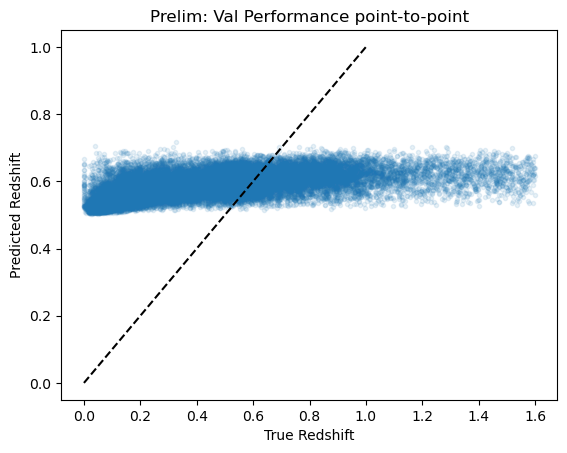

In [118]:
plt.plot(data_y_eval.flatten(),all_y_hat,'.',alpha=0.1)
plt.title('Prelim: Val Performance point-to-point')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.plot([0,1.0],[0,1.0],'k--')
plt.show()

In [28]:
all_z = data_y_eval.flatten() #alias

In [29]:
residuals_scaled = (all_y_hat - all_z.squeeze())/(1+all_z.squeeze())
#Using Pasquet's definition

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)
#CRPS_ = CRPS(torch.from_numpy(all_cde_hat).cuda(),data_y_val.cuda()).detach().cpu().numpy()

print('My Performance on the Entire Dataset: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')
#print('CRPS: ',np.round(100*CRPS_,6))
print('\n')
print('Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.')

My Performance on the Entire Dataset: 
MAD:  0.178762
BIAS:  -0.136131
ETA:  66.968907 % >0.05


Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.


### Compare to MGS, Beck, WISE-PS1-STRM

how many in MGS mask:  3205
My Performance on MGS: 
MAD:  0.01609
BIAS:  0.005057
ETA:  2.652106 % >0.05


Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.


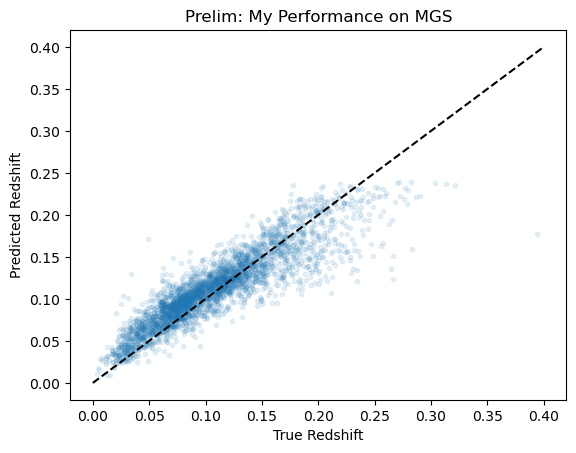

In [30]:
#BECK_PZ_val
#BECK_wps_PZ_val

#FIRST get our results using only MGS
residuals_scaled = (all_y_hat - all_z.squeeze())/(1+all_z.squeeze())
MGS_mask = ~np.isnan(photoz_MGS)

print('how many in MGS mask: ',np.sum(MGS_mask))
residuals_scaled = residuals_scaled[MGS_mask]
#Using Pasquet's definition

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)

print('My Performance on MGS: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')
print('\n')
print('Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.')

plt.plot(all_z.squeeze()[MGS_mask],all_y_hat[MGS_mask],'.',alpha=0.1)
plt.title('Prelim: My Performance on MGS')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.plot([0,0.4],[0,0.4],'k--')
plt.show()

how many in Beck LLR:  3204
Beck Local Linear Regression MGS: 
MAD:  0.013746
BIAS:  0.000673
ETA:  1.092385 % >0.05




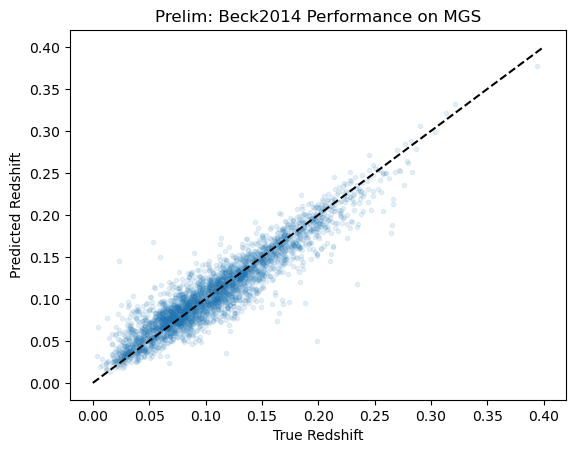

In [31]:
#Next compare to Beck's result on the same MGS sample

residuals_scaled = (photoz_MGS - all_z.squeeze())/(1+all_z.squeeze())

residuals_scaled = residuals_scaled[MGS_mask]
mask_residuals = abs(residuals_scaled)<100
residuals_scaled = residuals_scaled[mask_residuals]
#Using Pasquet's definition

print('how many in Beck LLR: ',len(residuals_scaled))
MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)

print('Beck Local Linear Regression MGS: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')
print('\n')

plt.plot(all_z.squeeze()[MGS_mask][mask_residuals],photoz_MGS[MGS_mask][mask_residuals],'.',alpha=0.1)

    
plt.title('Prelim: Beck2014 Performance on MGS')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.plot([0,0.4],[0,0.4],'k--')
plt.show()

how many in WISE-PS1-STRM mask:  18248
My Performance on WISE-PS1-STRM: 
MAD:  0.155648
BIAS:  -0.138089
ETA:  64.5879 % >0.05




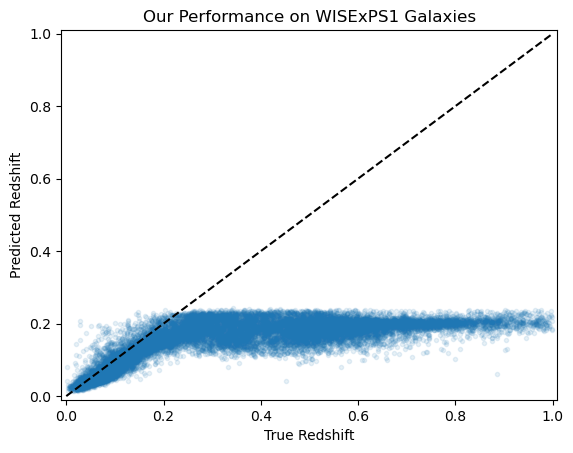

In [27]:
#Next compare to all the available matches in WISE-PS1-STRM
residuals_scaled = (all_y_hat - all_z.squeeze())/(1+all_z.squeeze())

wps_mask = ~np.isnan(photoz_WPS)

print('how many in WISE-PS1-STRM mask: ',np.sum(wps_mask))
residuals_scaled = residuals_scaled[wps_mask]
#Using Pasquet's definition

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)

print('My Performance on WISE-PS1-STRM: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')
print('\n')

plt.plot(all_z.squeeze()[wps_mask],all_y_hat[wps_mask],'.',alpha=0.1)
plt.title('Our Performance on WISExPS1 Galaxies')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.plot([0,1.0],[0,1.0],'k--')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.show()

how many in WISE-PS1-STRM mask:  18248
Pasquets Defintions: 
MAD:  0.017814
BIAS:  0.001773
ETA:  7.787155 % >0.05


Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.


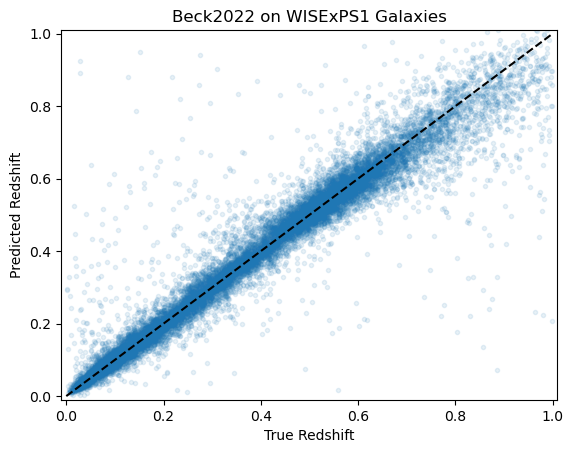

In [28]:
#Next compare to all the available matches in WISE-PS1-STRM


residuals_scaled = (photoz_WPS - all_z.squeeze())/(1+all_z.squeeze())
print('how many in WISE-PS1-STRM mask: ',np.sum(wps_mask))
residuals_scaled = residuals_scaled[wps_mask]
#Using Pasquet's definition

MAD = 1.4826*np.median(abs(residuals_scaled - np.median(residuals_scaled)))
BIAS = np.mean(residuals_scaled)
ETA = np.sum(abs(residuals_scaled)>=0.05)/len(residuals_scaled)

print('Pasquets Defintions: ')
print('MAD: ',np.round(MAD,6))
print('BIAS: ',np.round(BIAS,6))
print('ETA: ',np.round(100*ETA,6),'% >0.05')
print('\n')
print('Though, recall that ETA doesnt account for what I consider to be a catastrophic outlier.')


plt.plot(all_z.squeeze()[wps_mask],photoz_WPS[wps_mask],'.',alpha=0.1)

plt.title('Beck2022 on WISExPS1 Galaxies')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.plot([0,1.0],[0,1.0],'k--')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.show()

# Bring in the visualizations

#### seems like my performance is down even compared to before...

#### point-to-point plot

In [71]:
MAX_Z = 1.0

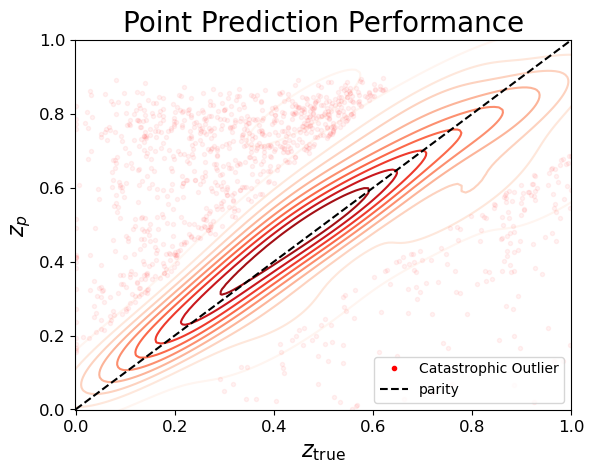

In [72]:
import seaborn as sns

sns.kdeplot(x=all_z[::500],y=all_y_hat[::500],cmap='Reds',)
residual = np.abs(all_z[:] - all_y_hat[:])/(1+all_z[:])
residual_mask = residual > 0.15
plt.plot(all_z[residual_mask],all_y_hat[:][residual_mask],'r.',alpha=0.05,)
plt.plot(-1,-1,'r.',alpha=1.0,label='Catastrophic Outlier')
plt.xlabel(r'$z_{\mathrm{true}}$',fontsize=16)
plt.ylabel(r'$z_{p}$',fontsize=16)
plt.plot([0,MAX_Z],[0,MAX_Z],'k--',label='parity')
plt.xlim(-0.001,MAX_Z)
plt.ylim(-0.001,MAX_Z)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'Point Prediction Performance',fontsize=20)
plt.savefig(f'./../IMAGES/errorbars_alloutliers.png',bbox_inches="tight",dpi=600)
plt.legend(loc='lower right')
plt.show()

# Uncertainty

## Overlay credible regions from a random sample

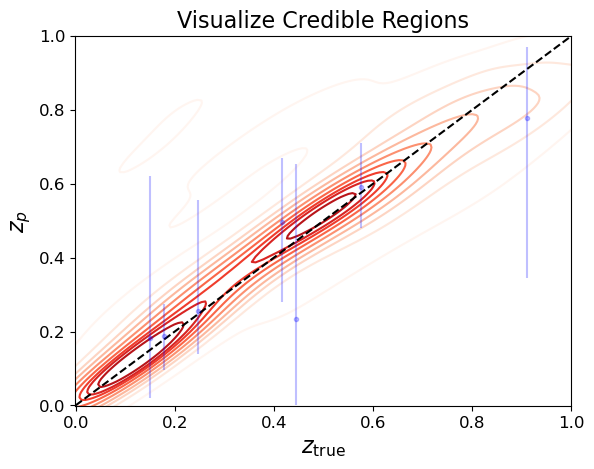

In [73]:
#Calculate uncertainty as [0.05,0.95] confidence regions (90% confidence regions)
##################################
residual = np.abs(all_z[:] - all_y_hat)/(1+all_z[:])
residual_mask = residual > 0.0

#for points with residual mask = True, calculate error bars above and below

cumulative_probability = np.cumsum(all_cde_hat,axis=1)
below_index = np.argmin(abs(cumulative_probability - 0.05),axis=1)
above_index = np.argmin(abs(cumulative_probability - 0.95),axis=1)

value_above = CLASS_BINS[above_index].cpu().numpy()[residual_mask] - all_y_hat[residual_mask]
value_below = all_y_hat[residual_mask] - CLASS_BINS[below_index].cpu().numpy()[residual_mask]

#this deals with point like distributions
value_above[value_above<0] = 0
value_below[value_below<0] = 0
##################################

sns.kdeplot(x=all_z[::50],y=all_y_hat[::50],cmap='Reds',)
plt.errorbar(x=all_z[residual_mask][::4000],y=all_y_hat[residual_mask][::4000],yerr=np.array([value_below,value_above])[:,::4000],fmt='b.',alpha=0.25)
plt.xlabel(r'$z_{\mathrm{true}}$',fontsize=16)
plt.ylabel(r'$z_{p}$',fontsize=16)
plt.plot([0,MAX_Z],[0,MAX_Z],'k--',label='parity')
plt.xlim(-0.001,MAX_Z)
plt.ylim(-0.001,MAX_Z)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'Visualize Credible Regions',fontsize=16)
plt.savefig(f'./../IMAGES/V1p0errorbars_radnom.png',bbox_inches="tight",dpi=600)
plt.show()

### Overlay credible regions from identified ETA catastrophic outliers

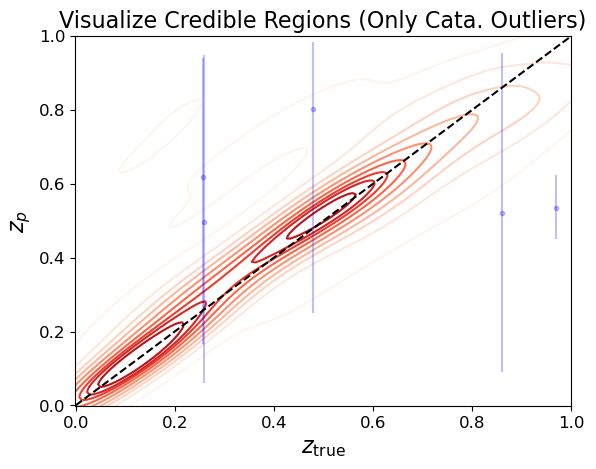

In [74]:
#Calculate uncertainty as [0.05,0.95] confidence regions (90% confidence regions)
##################################
residual = np.abs(all_z[:] - all_y_hat)/(1+all_z[:])
residual_mask = residual > 0.15

#for points with residual mask = True, calculate error bars above and below

cumulative_probability = np.cumsum(all_cde_hat,axis=1)
below_index = np.argmin(abs(cumulative_probability - 0.05),axis=1)
above_index = np.argmin(abs(cumulative_probability - 0.95),axis=1)

value_above = CLASS_BINS[above_index].cpu().numpy()[residual_mask] - all_y_hat[residual_mask]
value_below = all_y_hat[residual_mask] - CLASS_BINS[below_index].cpu().numpy()[residual_mask]

#this deals with point like distributions
value_above[value_above<0] = 0
value_below[value_below<0] = 0
##################################

sns.kdeplot(x=all_z[::50],y=all_y_hat[::50],cmap='Reds',)
plt.errorbar(x=all_z[residual_mask][::250],y=all_y_hat[residual_mask][::250],yerr=np.array([value_below,value_above])[:,::250],fmt='b.',alpha=0.25)
plt.xlabel(r'$z_{\mathrm{true}}$',fontsize=16)
plt.ylabel(r'$z_{p}$',fontsize=16)
plt.plot([0,MAX_Z],[0,MAX_Z],'k--',label='parity')
plt.xlim(-0.001,MAX_Z)
plt.ylim(-0.001,MAX_Z)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'Visualize Credible Regions (Only Cata. Outliers)',fontsize=16)
plt.savefig(f'./../IMAGES/V1p0errorbars_etaoutliers.png',bbox_inches="tight",dpi=600)
plt.show()

### Overlay credible regions from my definition of catastrophic outliers (>99% region off)

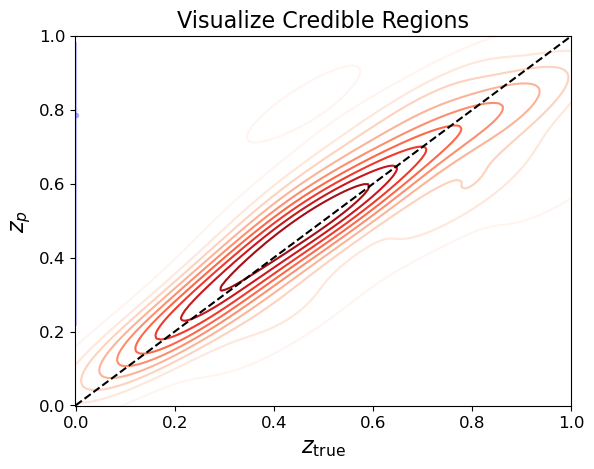

Percentage of >99percent outliers (we expect this to be 1percent): 0.22%


In [75]:
##################################
residual = np.abs(all_z[:] - all_y_hat)/(1+all_z[:])

#for points with residual mask = True, calculate error bars above and below

cumulative_probability = np.cumsum(all_cde_hat,axis=1)
below_index = np.argmin(abs(cumulative_probability - 0.05),axis=1)
above_index = np.argmin(abs(cumulative_probability - 0.95),axis=1)

value_above = CLASS_BINS[above_index].cpu().numpy() - all_y_hat
value_below = all_y_hat - CLASS_BINS[below_index].cpu().numpy()


#this deals with point like distributions
value_above[value_above<0] = 0
value_below[value_below<0] = 0


#FOR THIS, calculate a 99 credible region
below_index2 = np.argmin(abs(cumulative_probability - 0.005),axis=1)
above_index2 = np.argmin(abs(cumulative_probability - 0.995),axis=1)
value_above2 = CLASS_BINS[above_index2].cpu().numpy() - all_y_hat
value_below2 = all_y_hat - CLASS_BINS[below_index2].cpu().numpy()
value_above2[value_above2<0] = 0
value_below2[value_below2<0] = 0

#if true value is no within predicted_value[i]-value_below2[i],predicted_value[i]+value_above[i]
#then the mask is true.
residual_mask = np.logical_or(all_z<all_y_hat-value_below2,all_z>all_y_hat+value_above2)
# for i in range(len(all_z)):
#     if :
        


##################################

sns.kdeplot(x=all_z[::500],y=all_y_hat[::500],cmap='Reds',)
plt.errorbar(x=all_z[residual_mask][::100],y=all_y_hat[residual_mask][::100],
             yerr=np.array([value_below,value_above])[:,residual_mask][:,::100],
             fmt='b.',alpha=0.25,label='90% Credible Regions')
plt.xlabel(r'$z_{\mathrm{true}}$',fontsize=16)
plt.ylabel(r'$z_{p}$',fontsize=16)
plt.plot([0,MAX_Z],[0,MAX_Z],'k--',label='parity')
plt.xlim(-0.001,MAX_Z)
plt.ylim(-0.001,MAX_Z)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'Visualize Credible Regions',fontsize=16)
plt.savefig(f'./../IMAGES/V1p0errorbars_myouterliers.png',bbox_inches="tight",dpi=600)
plt.show()

print('Percentage of >99percent outliers (we expect this to be 1percent): {:.2f}%'.format(100*residual_mask.sum()/len(residual_mask)))

#### PIT plot

In [76]:
def PIT(X,Out,title='title',string='plot.png',save=False,n_classes=180,show=True):
    """
    X = spectro Z array
    Out = probabilities array
    """
    X_true_bin = np.argmin(abs(X - np.linspace(0.0,MAX_Z,n_classes+1)[None,:]),axis=1)
    X_true_bin[X_true_bin>=n_classes] = n_classes-1 
    PIT = []

    for i in range(len(X_true_bin)):
        PIT.append(np.sum((Out[i,:])[0:X_true_bin[i]]))

    PIT=np.asarray(PIT)
    
    Pbins=np.linspace(0,1,n_classes+1)
    #draw the line that is if it was a perfect distribution. it would have..
    #len(PIT)/180 #number in each bin
    fig = plt.figure(figsize=(6,5))
    plt.hlines((len(PIT)/n_classes),0,1,colors='k',linestyles='solid',linewidth=4.0)
    plt.xlim(0-0.02,1+0.02)
    plt.hist(PIT,Pbins)
    plt.title(title,fontsize=16)
    plt.xlabel('Cumulative Probability Bins',fontsize=18)
    plt.ylabel('Occurences',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #if save==True:
    plt.savefig(f'./../IMAGES/V1p0_PIT.png',bbox_inches="tight",dpi=600)
    if show:
        plt.show()
    else:
        return fig

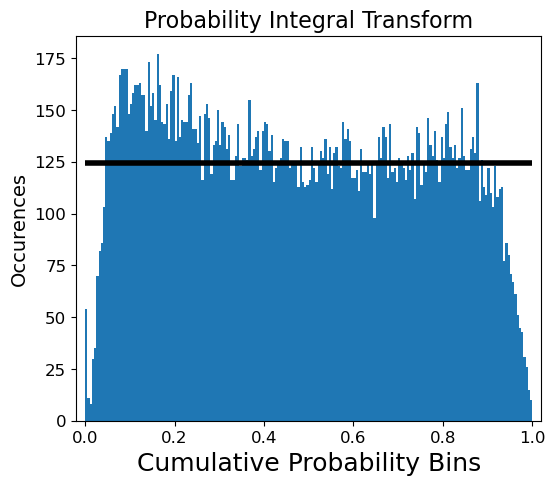

In [77]:
PIT(all_z[:,None],all_cde_hat,title=f'Probability Integral Transform',save=False,n_classes=N_CLASSES)

# Plot the galaxy next to the representation of the model variance over augmentations

In [76]:
np.random.seed(1)
INDICES = np.random.choice(np.arange(0,len(data_x_eval_unwise)),12,replace=False)
model.train(False)
outer_ps = []
for index in INDICES:
    inner_ps = []
    for i in range(20):
        with torch.no_grad():
            x_galex = data_x_eval_galex[index:index+1].cuda()
            x_ps = data_x_eval_ps[index:index+1].cuda()
            x_unwise = data_x_eval_unwise[index:index+1].cuda()
            y = data_y_eval[index:index+1].cuda()
            ebv = ebvs_eval[index:index+1].cuda()
            
            #Take care of transforms as part of augmentation
            x_galex, x_ps, x_unwise = augment_fn(x_galex,x_ps,x_unwise)

            #finally stack everything into single input x
            #x = torch.concat([x_galex,x_ps,x_unwise],dim=1)
            #if np.random.random() > 0.5:
            #    y_hat = model(x_ps,x_unwise,x_galex,ebv)
            #else:
            if LATEFUSION:
                y_hat = model(x_ps,x_unwise,x_galex,ebvs)
            else:
                x = torch.concatenate([x_galex,x_ps,x_unwise],1)
                y_hat = model(x,ebv)
            #x = torch.concat([x_galex,x_ps,x_unwise],dim=1)
            
        
            inner_ps.append(torch.nn.functional.softmax(y_hat,1).cpu().numpy())
    inner_ps = np.array(inner_ps)[:,0,:]
    outer_ps.append(inner_ps)
    
outer_ps = np.stack(outer_ps)

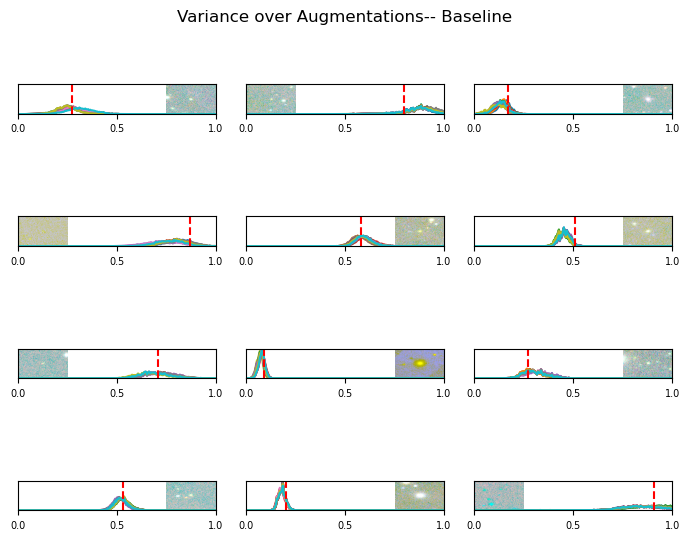

In [77]:
transform = AsinhStretch() + PercentileInterval(90.5)
fig = plt.figure(figsize=(7,6))
for counter,index in enumerate(INDICES):
    plt.subplot(4,3,counter+1)
    for i in range(20):
        plt.plot(CLASS_BINS.cpu().numpy(),outer_ps[counter,i])
    plt.vlines(data_y_eval[index],0,0.95,color='red',linestyle='dashed')
    plt.ylim(0,0.15)
    plt.xlim(0,1.0)
    plt.yticks([])
    plt.xticks([0.0,0.5,1.0],fontsize=7)
    
    img = np.load(get_photopath(data_index_eval[index]),allow_pickle=True).item()
    img_ps = img['panstarrs']
    
    b_ratio = np.mean(img_ps[2])/np.mean(img_ps[0])
    r_ratio = np.mean(img_ps[2])/np.mean(img_ps[4])
    g_ratio = np.mean(img_ps[2])/np.mean(img_ps[2])
    
    rgb_panstarrs = transform(np.array([r_ratio*img_ps[4,], g_ratio*img_ps[2,], b_ratio*img_ps[0,]]))
    rgb_panstarrs = rearrange(rgb_panstarrs,'f h w -> h w f')
    if data_y_test[index] < 0.6:
        plt.imshow(rgb_panstarrs,extent=(0.75,1.0,0.00,0.15))
    else:
        plt.imshow(rgb_panstarrs,extent=(0.00,0.25,0.00,0.15))

plt.tight_layout()
plt.suptitle('Variance over Augmentations-- Baseline')
plt.show()